In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext
import skfuzzy as fuzz

In [2]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [3]:
def showSubplotImage(img, titlestr=""):
    plt.imshow(img, cmap='gray', interpolation='bicubic', vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])
    plt.title(titlestr)
    plt.show()

def setSubplotImage(img, titlestr=""):
    n = len(img)  # Number of images
    
    if n <= 6:
        # If 6 or fewer images, show in a single row
        cols = n
        rows = 1
    else:
        # Otherwise, calculate rows and columns
        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axes for easy indexing

    for i in range(n):
        axs[i].imshow(img[i], cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titlestr[i] if i < len(titlestr) else "")
        axs[i].axis('off')  # Turn off axes

    # Hide any unused subplots
    for i in range(n, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
kernel = np.ones((5,5),np.uint8)

morph_map ={
    'open':cv2.MORPH_OPEN,
    'close':cv2.MORPH_CLOSE,
    'gradient':cv2.MORPH_GRADIENT,
    'tophat':cv2.MORPH_TOPHAT,
    'blackhat':cv2.MORPH_BLACKHAT,
    'dilation':cv2.MORPH_DILATE ,
    'erosion':cv2.MORPH_ERODE
}

def multiple_MORPH(img, kernel, iterations,option):
    morph_type = morph_map.get(option)
    exp = cv2.morphologyEx(img, morph_type, kernel, iterations=iterations)
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(122), plt.imshow(exp, cmap='gray')
    plt.title(f'Morphological {option}'), plt.axis('off')
    plt.show()
    return exp

In [5]:
def sharpening_img(img ,size=5):
    
    blurrer_img = cv2.GaussianBlur(img,(size,size),0)

    sm_img = cv2.blur(blurrer_img,(size,size)).astype(np.float32)


    detail_img = blurrer_img - sm_img
    outImg = np.clip(blurrer_img + detail_img, 0, 255).astype(np.uint8)


    return outImg

In [6]:

def sobel_process(img):
    #gradient_process and angle orientation
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)

    mag1 = np.sqrt(sobelx**2 + sobely**2)
    gradient_magnitude = cv2.normalize(mag1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    angle = np.arctan2(sobely, sobelx)

    return mag1,gradient_magnitude ,angle



In [7]:
def processingImage(img):

    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]
    clahe_2 = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    clahe_2_img = clahe_2.apply(green_channel)

    # laplacian = cv2.Laplacian(clahe_2_img,cv2.CV_8U)
    baliterail = cv2.bilateralFilter(clahe_2_img,d=8,sigmaColor=75, sigmaSpace=75) #reduce noise
    c_mean = cv2.adaptiveThreshold(clahe_2_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV, 11, 5)

    setSubplotImage([baliterail,clahe_2_img,c_mean],titlestr=["baliter_sp_img","sp_img","c_mean_sp_img"]);

    sp_img =sharpening_img(clahe_2_img)
    baliter_sp_img = sharpening_img(baliterail)
    c_mean_sp_img = sharpening_img(c_mean)

    setSubplotImage([baliter_sp_img,sp_img,c_mean_sp_img],titlestr=["baliter_sp_img","sp_img","c_mean_sp_img"]);

    mag1,mag2 =sobel_process(sp_img)
    mag1_b,mag2_b =sobel_process(baliter_sp_img)
    mag1_c,mag2_c =sobel_process(c_mean_sp_img)

    setSubplotImage([mag1,mag1_b,mag1_c],titlestr=["mag1","mag1_b",'mag1_c']);

    setSubplotImage([mag2_b,mag2,mag2_c],titlestr=["mag2_b","mag2",'mag2_c']);
    return mag2

In [8]:
import cv2
import numpy as np

def apply_CLAHE(img, clip_limit, tile_grid_size=(15, 15)):
    # Apply CLAHE to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def gaussian_blur(img, kernel_size, sigma):
    # Apply Gaussian smoothing
    return cv2.GaussianBlur(img, kernel_size, sigma)

def sobel_function(img):
    # Calculate Sobel gradients
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate gradient magnitude and direction
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    direction = np.arctan2(grad_y, grad_x) * 180 / np.pi

    # Normalize gradient magnitude
    # magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return magnitude, direction


def non_maximum_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z



def double_threshold(img, low_threshold, high_threshold):
    # Apply double threshold
    strong = np.zeros_like(img, dtype=np.uint8)
    weak = np.zeros_like(img, dtype=np.uint8)
    strong[img >= high_threshold] = 255
    weak[(img >= low_threshold) & (img < high_threshold)] = 128
    return strong, weak

def hysteresis(strong, weak):
    # Apply hysteresis to track edges
    final_edges = np.copy(strong)
    h, w = strong.shape
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if weak[i, j] == 128:
                if np.any(strong[i - 1:i + 2, j - 1:j + 2] == 255):
                    final_edges[i, j] = 255
                else:
                    final_edges[i, j] = 0
    return final_edges

def remove_fundus_outline(canny_img, green_channel):
    # Create binary mask of fundus outline
    _, binary_mask = cv2.threshold(green_channel, 15, 255, cv2.THRESH_BINARY)
    eroded_mask = cv2.erode(binary_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    return cv2.bitwise_and(canny_img, eroded_mask)

def modified_canny(img, clip_limit=0.00023, tile_grid_size=(15, 15),
                   kernel_size=(15, 15), sigma=0.5, low_threshold=50, high_threshold=150):
   
    
    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]
    clahe_img = apply_CLAHE(green_channel, clip_limit, tile_grid_size)
    
    # Gaussian blur
    blurred = gaussian_blur(clahe_img, kernel_size, sigma)
    # blurred = cv2.bilateralFilter(clahe_img,d=8,sigmaColor=75, sigmaSpace=75)
    blurred = sharpening_img(blurred)
    
    # Compute gradients and suppress non-maximum
    magnitude, direction = sobel_function(blurred)
    suppressed = non_maximum_suppression(magnitude, direction)

    high_threshold = np.percentile(suppressed, 90)
    # Low threshold: fraction (b) of high threshold
    low_threshold = 0.3 * high_threshold
    
    # Thresholding and hysteresis
    strong, weak = double_threshold(suppressed, low_threshold, high_threshold)
    edges = hysteresis(strong, weak)
    
    # Remove fundus outline
    final_edges = remove_fundus_outline(edges, green_channel)

    _, binary_img = cv2.threshold(final_edges, 127, 255, cv2.THRESH_BINARY)
    binary_img = binary_img/255

    print(binary_img)


    setSubplotImage([clahe_img,magnitude,direction,suppressed,edges,final_edges],
                    titlestr=[ 'clahe_img' , 'magnitude',"direction","suppressed","edges","final_edges"]);
    
    return final_edges




In [9]:
kernel = np.ones((5,5),np.uint8)

morph_map ={
    'open':cv2.MORPH_OPEN,
    'close':cv2.MORPH_CLOSE,
    'gradient':cv2.MORPH_GRADIENT,
    'tophat':cv2.MORPH_TOPHAT,
    'blackhat':cv2.MORPH_BLACKHAT,
    'dilation':cv2.MORPH_DILATE ,
    'erosion':cv2.MORPH_ERODE
}

def multiple_MORPH(img, kernel, iterations,option):
    morph_type = morph_map.get(option)
    exp = cv2.morphologyEx(img, morph_type, kernel, iterations=iterations)
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(122), plt.imshow(exp, cmap='gray')
    plt.title(f'Morphological {option}'), plt.axis('off')
    plt.show()
    return exp

In [10]:
from sklearn.cluster import KMeans

def kMeans (img) :
    # Step 1: Load the image

    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    green_channel = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]
    enhanced_img = apply_CLAHE(green_channel, 2, (8,8))
    enhanced_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)

    mag1,gradient_magnitude ,angle = sobel_process(enhanced_img)

    sobel_mag = np.uint8(mag1)

    # Step 2: Flatten the image into a 1D array
    pixel_values = sobel_mag.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)  # Convert to float

    k = 15  # Number of clusters (vessel and background)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8 and map labels to image
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(enhanced_img.shape)



    # Post-process the segmented image
    _, binary_img = cv2.threshold(segmented_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    setSubplotImage([enhanced_img, segmented_image, binary_img],["enhanced_img","segmented_image","binary_img"])


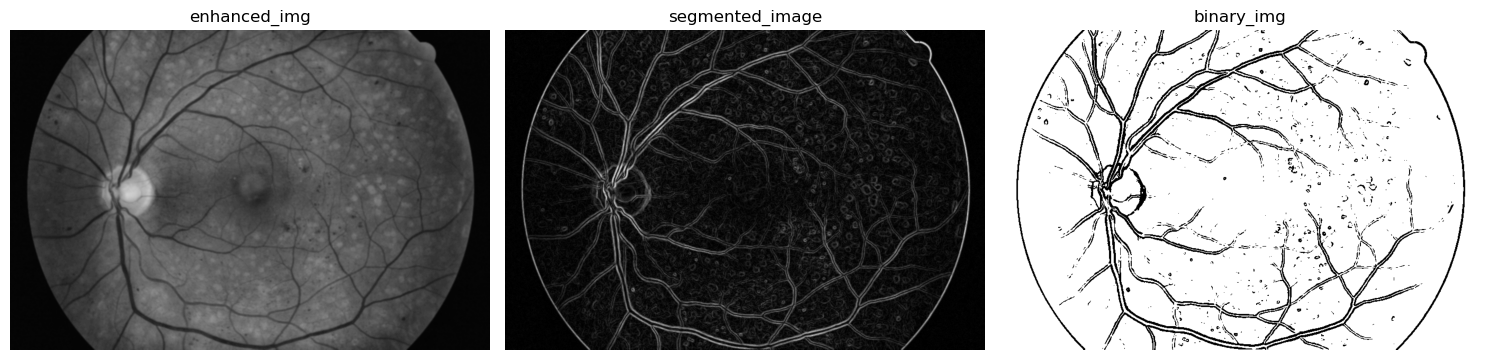

KeyboardInterrupt: 

In [11]:
for i,name in enumerate(files):
    inputImg = cv2.imread(input_dir + '/' + name)
    output = kMeans(inputImg)


#     # for option in morph_map.keys():
#     #     print(f"Applying Morphological Operation: {option}")
#     #     multiple_MORPH(output, kernel, 1, option)